<a href="https://colab.research.google.com/github/WittmannF/course/blob/master/day-4/assignment-3-cats-dogs-solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Cats vs Dogs Classifier
In this project we are going to use transfer learning in order to buid a classifier to distinguish cats and dogs. As database, we will be using a subset from the Kaggle Competition: https://www.kaggle.com/c/dogs-vs-cats/. While the original dataset has 25000 images, you are going to use only 2000 images for training the model. As you will notice by the end of this project, thanks to transfer learning, we can get  great classification results even with smaller datasets. 

> **NOTE:** *Make sure to complete all the lines of code with a `TODO:` comment.*

## 1. Access the Dataset
Run the cells bellow in order to mount your Google Drive (if using colab) and download the dataset. The dataset is also available to be manually downloaded in [this repository](https://github.com/dl7days/datasets).

### 1.1 Mount Google Drive (if using Colab)
Let's mount Google Drive in order to download the dataset. This way you won't have to always download again the dataset when accessing the notebook.

In [0]:
import sys, os

MOUNT_GDRIVE = True # Choose Google Drive
USING_COLAB = 'google.colab' in sys.modules

# Update here with the folder of the files of your course
COURSE_DIRECTORY = '/content/drive/My Drive/course/day-3'

if MOUNT_GDRIVE and USING_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Create course directory if it doesn't exist (if not cloned from github)
    if not os.path.exists(COURSE_DIRECTORY):
        os.makedirs(COURSE_DIRECTORY)
    # Open course directory
    os.chdir(COURSE_DIRECTORY)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 1.2 Download Dataset
Now, let's download the dataset if it is the first time you are running this cell (i.e., if the dataset folder was not found): 

In [0]:
import os

DATA_PATH = 'cats-dogs-data/'
DATA_URL = 'https://github.com/dl7days/datasets/raw/master/cats-dogs-data.zip'
ZIP_FILENAME = 'cats-dogs-data.zip'

if not os.path.exists(DATA_PATH):# If dataset folder doesn't exist
    try: # Then try downloading and unzipping it
        print("Downloading Dataset...")
        os.system(f"wget {DATA_URL}")

        print("Unzipping Dataset")
        os.system(f"unzip {ZIP_FILENAME}")

        print("Removing .zip file")
        os.system(f"rm {ZIP_FILENAME}")
    except Exception as e: # If there's an error, ask to download manually
        print(f"Something went wrong. Please download the dataset manually at {DATA_URL}")
        print(f'The following exception was thrown:\n{e}')
else:
    print(f'Dataset folder {DATA_PATH} has been found')

Dataset folder cats-dogs-data/ has been found


In [0]:
# Assign training and validation folders
TRAIN_PATH = f'{DATA_PATH}train/'
VALID_PATH = f'{DATA_PATH}valid/'

## 2. Visualize Images from the Dataset
Now, let's visualize some of the images available in the training folder. First let's load a list with all filepaths:

In [0]:
import glob

filepaths = glob.glob(TRAIN_PATH+'/cat/*.jpg')
for f in glob.glob(TRAIN_PATH+'/dog/*.jpg'):
    filepaths.append(f)

Now, let's visualize a random image from the dataset. Every time you run the next cell, a random image (either of a dog or a cat) is going to be displayed:

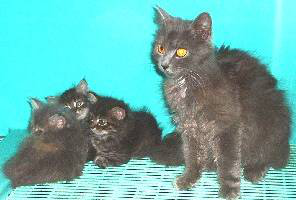

In [0]:
from keras.preprocessing.image import load_img
import random

load_img(random.choice(filepaths))

## 3. Applying Transfer Learning

### 3.1 Defining Image Data Generators
Your first task is to define a training and a validation generator for loading the dataset. Follow those steps:
1. First of al, you will choose any model of your choice in https://keras.io/applications to be imported (for example ResNet50)
2. Next, import the model itself and the `preprocess_input` function (for example `from keras.applications.resnet50 import ResNet50, preprocess_input`)
3. Import the ImageDataGenerator from the [image preprocessing module](https://keras.io/preprocessing/image/)
4. Initialize the data generator class including the argument `preprocessing_function` as the `preprocess_input` function imported from the transfer learning model. This way all images are going to be preprocessed in the same settings of the images that were trained in the imported model.
5. Define the training and validationg generators using the method `flow_from_directory`. Add the variables `TRAIN_PATH` and `VALID_PATH` as the path of each of each one. 

In [0]:
# TODO: Import the model and the preprocess_input function
from keras.applications.resnet50 import ResNet50, preprocess_input

# TODO: Import the ImageDataGenerator class
from keras.preprocessing.image import ImageDataGenerator

# Shape in which all images are going to be reshaped
TARGET_SHAPE = (224, 224, 3)

# TODO: Initialize the data generator class 
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# TODO: Create the training and validation generators using the method flow_from_directory
train_loader = datagen.flow_from_directory(TRAIN_PATH, target_size=TARGET_SHAPE[:2], class_mode='sparse')
valid_loader = datagen.flow_from_directory(VALID_PATH, target_size=TARGET_SHAPE[:2], class_mode='sparse')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### 3.2 Defining Base Model

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D

# 1. Import pre-trained model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

# 2. Initialize base model
base_model = ResNet50(include_top=False, input_shape=TARGET_SHAPE)

# 3. Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable=False
    
# 4. Add Fully connected layer
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dense(2, activation='softmax')])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### 3.3 Training Model
First let's compile the model. The optimizer and loss function as already been chosen for you. We are going to use as loss function `sparse_categorical_crossentropy` which is useful when the target contains classes represented as integer values (1 and 0 in our case). The learning rate of Adam was set to 1e-4 since the default value (1e-3) was too big and leading to unstabilities. We'll learning how to better define the learning rate in the next day. 

In [0]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit_generator(train_loader, train_loader.n//train_loader.batch_size, epochs=3,
                    validation_data=valid_loader, validation_steps=valid_loader.n//valid_loader.batch_size)

Epoch 1/3
62/62 [==============================] - 17s 278ms/step - loss: 0.1790 - acc: 0.9224 - val_loss: 0.0739 - val_acc: 0.9701
Epoch 2/3
62/62 [==============================] - 11s 180ms/step - loss: 0.0513 - acc: 0.9829 - val_loss: 0.0323 - val_acc: 0.9864
Epoch 3/3
62/62 [==============================] - 12s 197ms/step - loss: 0.0474 - acc: 0.9829 - val_loss: 0.0478 - val_acc: 0.9891


In [0]:
model.fit_generator(train_loader, train_loader.n//train_loader.batch_size, epochs=3,
                    validation_data=valid_loader, validation_steps=valid_loader.n//valid_loader.batch_size)

Epoch 1/3
62/62 [==============================] - 13s 210ms/step - loss: 0.0224 - acc: 0.9934 - val_loss: 0.0271 - val_acc: 0.9891
Epoch 2/3
62/62 [==============================] - 12s 199ms/step - loss: 0.0257 - acc: 0.9919 - val_loss: 0.0288 - val_acc: 0.9946
Epoch 3/3
62/62 [==============================] - 12s 200ms/step - loss: 0.0232 - acc: 0.9920 - val_loss: 0.0334 - val_acc: 0.9918


## 4. Visualize Predictions
Now, let's check predictions from an image obtained online. Find 5 links of either cats or dogs in order to check your predictions, for example:
```
URLS = ['http://example.com/image1.jpg',
        'http://example.com/image2.jpg',
        'http://example.com/image3.jpg',
        'http://example.com/image4.jpg',
        'http://example.com/image5.jpg']
        
```

In [0]:
URLS = ['https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg',
        'https://images.pexels.com/photos/20787/pexels-photo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/9/9e/Tabby_cat-3337027.jpg',
        'https://images.pexels.com/photos/162349/dog-hybrid-animal-lying-162349.jpeg',
        'https://images.pexels.com/photos/356378/pexels-photo-356378.jpeg']

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image

def predict_from_url(model, train_gen, url, target_shape=(224,224)):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_shape)

    # Convert to a Numpy array
    img_np = np.asarray(img)

    # Reshape by adding 1 in the beginning to be compatible as input of the model
    img_np = img_np[None] # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis

    # Prepare the image for the model
    img_np = preprocess_input(img_np)

    # Decode output of model into classes and probabilities
    result = model.predict(img_np)
 
    class_indices = train_gen.class_indices    
    index_to_class = {v: k for k, v in class_indices.items()}
    
    # Displaying image
    plt.imshow(img)
    plt.title(f'Predicted Class: {index_to_class[result.argmax()]}')
    plt.show()
    
    

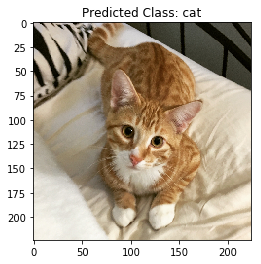

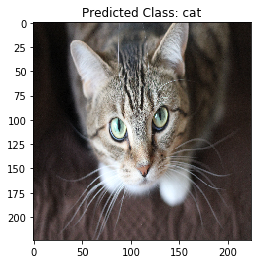

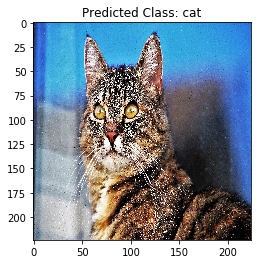

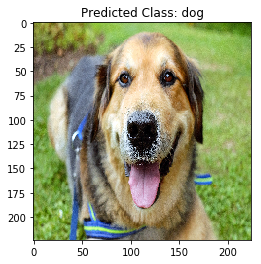

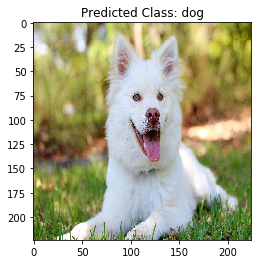

In [0]:
for url in URLS:
    predict_from_url(model, train_loader, url, target_shape=TARGET_SHAPE[:2])